In [1]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1337)  
from keras.preprocessing import sequence
from keras.regularizers import l2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer, MinMaxScaler
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [2]:
traindata = pd.read_csv('kddtrain.csv', header=None)
traindata.columns= ["threat", "duration","protocol_type","service","flag","src_bytes","dst_bytes","land"
                         ,"wrong_fragment","urgent","hot","num_failed_logins","logged_in", 
                          "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations"
                         ,"num_shells", "num_access_files","num_outbound_cmds","is_host_login","is_guest_login"
                         ,"count", "srv_count","serror_rate", "srv_serror_rate","rerror_rate","srv_rerror_rate"
                         ,"same_srv_rate","diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count"
                         ,"dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate"
                         ,"dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
testdata = pd.read_csv('kddtest.csv', header=None)
testdata.columns = traindata.columns
traindata = traindata.drop(columns = ["num_outbound_cmds","is_host_login"])
testdata = testdata.drop(columns = ["num_outbound_cmds","is_host_login"])
traindata.head()

,threat,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,1,1,1,181,5450,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,0,1,1,1,239,486,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,0,1,1,1,235,1337,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,0,1,1,1,219,1337,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,0,1,1,1,217,2032,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


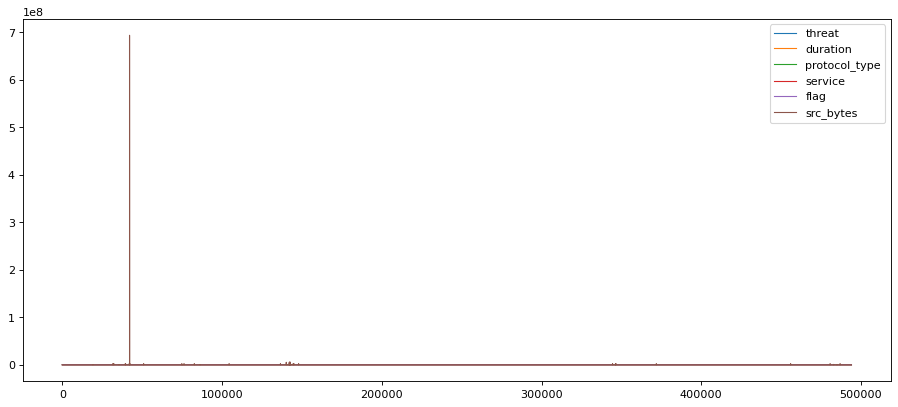

In [59]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
for i in range(6):
    ax.plot(traindata[traindata.columns[i]], label=traindata.columns[i], linewidth=1)
plt.legend()
plt.show()

In [3]:
trainvalues = traindata.values
trainvalues = trainvalues.astype('float32')
testvalues = testdata.values
testvalues = testvalues.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
trainvalues = scaler.fit_transform(trainvalues)

scaler = MinMaxScaler(feature_range=(0, 1))
testvalues = scaler.fit_transform(testvalues)

traindataset = trainvalues[0:len(trainvalues),:]
testdataset = testvalues[0:len(testvalues),:]

batch_size = 64
testdataset.shape


(311029, 40)

In [4]:
def create_dataset(dataset, timestep=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-timestep-1):
        a = dataset[i:(i+timestep), :]
        dataX.append(a)
        dataY.append(dataset[i + timestep, :])
    return np.array(dataX), np.array(dataY)

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
reframedtrain = series_to_supervised(traindataset)
reframedtrain.drop(reframedtrain.columns[list(i for i in range(41, 80))], axis=1, inplace=True)
reframedtest = series_to_supervised(testdataset)
reframedtest.drop(reframedtest.columns[list(i for i in range(41, 80))], axis=1, inplace=True)
reframedtrain[0:3]

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var32(t-1),var33(t-1),var34(t-1),var35(t-1),var36(t-1),var37(t-1),var38(t-1),var39(t-1),var40(t-1),var1(t)
1,0.0,0.0,0.0,0.0,0.0,2.610418e-07,0.001057,0.0,0.0,0.0,...,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,...,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,...,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
timestep = 1
#trainX, trainY = create_dataset(traindataset, timestep)
#testX, testY = create_dataset(testdataset, timestep)
valuestrain = reframedtrain.values
valuestest = reframedtest.values
trainX, trainY = valuestrain[:,:-1], valuestrain[:,-1]
testX, testY = valuestest[:,:-1], valuestest[:,-1]
print(trainX.shape)
print(trainY.shape)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
testY

(494020, 40)
(494020,)
(494020, 1, 40) (494020,) (311028, 1, 40) (311028,)


array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [8]:
l2_lambda = 0.0001
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), kernel_regularizer=l2(l2_lambda), dropout=0.01 ,recurrent_dropout=0.01, return_sequences=True))
model.add(Dense(256, kernel_regularizer=l2(l2_lambda), activation='relu'))  
model.add(Dropout(0.01))
model.add(BatchNormalization())
model.add(Dense(1, kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

In [11]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
checkpointer = callbacks.ModelCheckpoint(filepath="C:/Users/Shigatau/Documents/Диплом/Intrusion-Detection-Systems-master/dnn/kddresults/LSTM/check.hdf5", verbose=1, save_best_only=True, monitor='loss')
csv_logger = CSVLogger('C:/Users/Shigatau/Documents/Диплом/Intrusion-Detection-Systems-master/dnn/kddresults/LSTM/training_set_dnnanalysis.csv',separator=',', append=False)
history = model.fit(trainX, trainY,  batch_size=batch_size,validation_data=(testX, testY), verbose=2, epochs=100, callbacks=[checkpointer,csv_logger])
model.save("C:/Users/Shigatau/Documents/Диплом/dnn/kddresults/LSTM/dnn3layer_model.hdf5")

Epoch 1/100
7720/7720 - 26s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.3886 - val_accuracy: 0.9438

Epoch 00001: loss improved from inf to 0.00595, saving model to C:/Users/Shigatau/Documents/Диплом/Intrusion-Detection-Systems-master/dnn/kddresults/LSTM\check.hdf5
Epoch 2/100
7720/7720 - 23s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.3853 - val_accuracy: 0.9436

Epoch 00002: loss did not improve from 0.00595
Epoch 3/100
7720/7720 - 23s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.3764 - val_accuracy: 0.9452

Epoch 00003: loss did not improve from 0.00595
Epoch 4/100
7720/7720 - 23s - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.3733 - val_accuracy: 0.9431

Epoch 00004: loss improved from 0.00595 to 0.00590, saving model to C:/Users/Shigatau/Documents/Диплом/Intrusion-Detection-Systems-master/dnn/kddresults/LSTM\check.hdf5
Epoch 5/100
7720/7720 - 23s - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.3592 - val_accuracy: 0.9452

Epoch 00005: loss did not improve from 0.00590


7720/7720 - 23s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.3577 - val_accuracy: 0.9451

Epoch 00053: loss did not improve from 0.00590
Epoch 54/100
7720/7720 - 23s - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.3818 - val_accuracy: 0.9452

Epoch 00054: loss did not improve from 0.00590
Epoch 55/100
7720/7720 - 25s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.3582 - val_accuracy: 0.9452

Epoch 00055: loss did not improve from 0.00590
Epoch 56/100
7720/7720 - 22s - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.3948 - val_accuracy: 0.9432

Epoch 00056: loss did not improve from 0.00590
Epoch 57/100
7720/7720 - 23s - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.3816 - val_accuracy: 0.9452

Epoch 00057: loss did not improve from 0.00590
Epoch 58/100
7720/7720 - 23s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.3774 - val_accuracy: 0.9431

Epoch 00058: loss did not improve from 0.00590
Epoch 59/100
7720/7720 - 23s - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.3899 - val_accurac

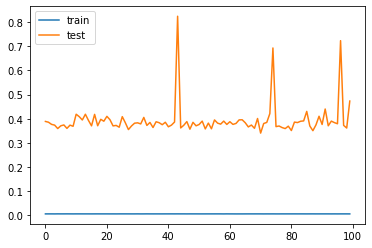

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
testY[0:3]

array([0., 0., 1.], dtype=float32)

In [46]:
score = []
name = []
from numpy import concatenate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import os
for file in os.listdir("C:/Users/Shigatau/Documents/Диплом/dnn/kddresults/LSTM/"):
    model.load_weights("C:/Users/Shigatau/Documents/Диплом/dnn/kddresults/LSTM/"+file)
    yhat = model.predict(testX)
    testX1 = testX.reshape((testX.shape[0], testX.shape[2]))
    yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))
    inv_yhat = concatenate((yhat, testX1[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    testY = testY.reshape((len(testY), 1))
    inv_y = concatenate((testY, testX1[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    for i in range(len(inv_yhat)):
        if inv_yhat[i]>0.5:
            inv_yhat[i] = 1
        else:
            inv_yhat[i] = 0
    accuracy = accuracy_score(inv_y, inv_yhat)
    recall = recall_score(inv_y, inv_yhat , average="binary")
    precision = precision_score(inv_y, inv_yhat , average="binary")
    f1 = f1_score(inv_y, inv_yhat, average="binary")
    print("----------------------------------------------")
    print("accuracy")
    print("%.3f" %accuracy)
    print("recall")
    print("%.3f" %recall)
    print("precision")
    print("%.3f" %precision)
    print("f1score")
    print("%.3f" %f1)
    score.append(accuracy)
    name.append(file)

----------------------------------------------
accuracy
0.918
recall
0.972
precision
0.929
f1score
0.950


In [50]:
np.savetxt("C:/Users/Shigatau/Documents/Диплом/Intrusion-Detection-Systems-master/dnn/dnnres/LSTMpredicted.txt", inv_yhat)

